In [1]:
import sys
import os
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers,regularizers,losses
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
from tensorflow.keras import utils
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt
import matplotlib
import SimpleITK as sitk
from skimage.transform import resize
from skimage import img_as_bool
import pickle
from random import randint

# Read Data

In [2]:
def read_image_from_path(INPUT_DIR,EXTENSION):
    all_images = []
    all_filenames = []
    for filename in os.listdir(INPUT_DIR):
        if filename.endswith(EXTENSION): 
            image = sitk.ReadImage(os.path.join(INPUT_DIR, filename))
            image_array = np.squeeze(np.asarray(sitk.GetArrayFromImage(image)))
            image_array = np.array(image_array, dtype=bool)
            image_resized = resize(image_array, (64, 64), mode='constant', anti_aliasing=False)
            all_images.append(image_resized)
            all_filenames.append(filename[:-11])
        data = np.array(all_images)
    return data, all_filenames

In [3]:
Data_proj1,filenames = read_image_from_path('./SubcorticalImages/Caudate/','CaudL_pp_surfSPHARM_procalign_proj1.nrrd')
print(Data_proj1.shape)
Data_proj2,_ = read_image_from_path('./SubcorticalImages/Caudate/','CaudL_pp_surfSPHARM_procalign_proj2.nrrd')
print(Data_proj2.shape)
Data_proj3,_ = read_image_from_path('./SubcorticalImages/Caudate/','CaudL_pp_surfSPHARM_procalign_proj3.nrrd')
print(Data_proj3.shape)

(478, 64, 64)
(478, 64, 64)
(478, 64, 64)


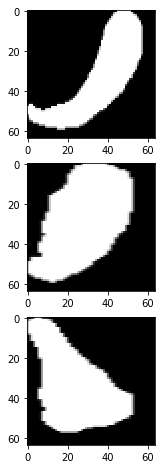

In [4]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(3, 1, 1)
plt.imshow(Data_proj1[0,:,:],cmap='gray')
fig.add_subplot(3, 1, 2)
plt.imshow(Data_proj2[0,:,:],cmap='gray')
fig.add_subplot(3, 1, 3)
plt.imshow(Data_proj3[0,:,:],cmap='gray')
plt.show()

In [5]:
# Save Data
Original_Images = np.zeros((Data_proj1.shape[0],3,Data_proj1.shape[1],Data_proj1.shape[2]))
Original_Images[:,0,:,:] = Data_proj1
Original_Images[:,1,:,:] = Data_proj2
Original_Images[:,2,:,:] = Data_proj3
print(Original_Images.shape)
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Original_Images.pkl'),'wb') as f:
    pickle.dump(Original_Images, f)
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Original_Images_Filenames.pkl'),'wb') as f:
    pickle.dump(filenames, f)

(478, 3, 64, 64)


# Preprocess Data 

In [6]:
X = np.vstack((Data_proj1,Data_proj2,Data_proj3))
X = np.expand_dims(X,  axis=-1)
print(X.shape)

(1434, 64, 64, 1)


# Deep Learning Model

In [7]:
# build encoder model
def encoder(kernel, filter, rows, columns, channel, latent_dim, usedropout=False, dropoutrate=0.2):

    inputs_x = layers.Input(shape=(rows, columns, channel), name='data_input')
    model    = layers.Conv2D(filters=filter, kernel_size=kernel, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(inputs_x)
    model    = layers.BatchNormalization(epsilon=1e-6)(model)
    model    = layers.LeakyReLU(0.2)(model)
    if usedropout:
        model    = layers.Dropout(dropoutrate)(model)
    model    = layers.Conv2D(filters=2*filter, kernel_size=kernel, strides=(2,2), padding='same', kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(model)
    model    = layers.BatchNormalization(epsilon=1e-6)(model)
    model    = layers.LeakyReLU(0.2)(model)
    if usedropout:
        model    = layers.Dropout(dropoutrate)(model)
    model    = layers.Conv2D(filters=4*filter, kernel_size=kernel, strides=(2,2), padding='same', kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(model)
    model    = layers.BatchNormalization(epsilon=1e-6)(model)
    model    = layers.LeakyReLU(0.2)(model)
    if usedropout:
        model    = layers.Dropout(dropoutrate)(model)
    model    = layers.Conv2D(filters=8*filter, kernel_size=kernel, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(model)
    model    = layers.BatchNormalization(epsilon=1e-6)(model)
    model    = layers.LeakyReLU(0.2)(model)

    model     = layers.Flatten()(model)
    z         = layers.Dense(latent_dim,name='z',kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(model)

    # instantiate encoder model
    encoder = models.Model(inputs_x, z, name='encoder')

    return encoder

In [8]:
# build decoder model
def decoder(kernel, filter, z_rows, z_columns, z_channel, x_channel, latent_dim, usedropout=False,dropoutrate=0.2):

    inputs_z = layers.Input(shape=(latent_dim,), name='z')
    model    = layers.Dense(z_rows*z_columns*z_channel , kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(inputs_z)
    model    = layers.Reshape((z_rows,z_columns,z_channel))(model)
    model    = layers.BatchNormalization(epsilon=1e-6)(model)
    model    = layers.LeakyReLU(0.2)(model)
    if usedropout:
        model    = layers.Dropout(dropoutrate)(model)
    model    = layers.Conv2DTranspose(filters=filter*16, kernel_size=kernel, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(model)
    model    = layers.BatchNormalization(epsilon=1e-6)(model)
    model    = layers.LeakyReLU(0.2)(model)
    if usedropout:
        model    = layers.Dropout(dropoutrate)(model)
    model    = layers.Conv2DTranspose(filters=filter*8, kernel_size=kernel, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(model)
    model    = layers.BatchNormalization(epsilon=1e-6)(model)
    model    = layers.LeakyReLU(0.2)(model)
    if usedropout:
        model    = layers.Dropout(dropoutrate)(model)
    model    = layers.Conv2DTranspose(filters=filter*4, kernel_size=kernel, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(model)
    model    = layers.BatchNormalization(epsilon=1e-6)(model)
    model    = layers.LeakyReLU(0.2)(model)
    if usedropout:
        model    = layers.Dropout(dropoutrate)(model)

    model    = layers.Conv2DTranspose(filters=x_channel, kernel_size=kernel, strides=(2,2), padding='same',kernel_regularizer=regularizers.l2(1e-5), kernel_initializer='he_uniform')(model)
    #model    = layers.BatchNormalization(epsilon=1e-6)(model)
    out      = layers.Activation('sigmoid', name='recons_input')(model)    

    # instantiate decoder model
    decoder = models.Model(inputs_z, out, name='decoder')
    return decoder

In [9]:
# Model Hyperparameters
W = 64
H = 64
C = 1
latent_dim = 10
usedropout = False
dropoutrate = 0.5

In [10]:
# instantiate encoder model
Enc = encoder((3,3), 16, W, H, C, latent_dim, usedropout, dropoutrate)
Enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_input (InputLayer)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
__________

In [11]:
# instantiate decoder model
Dec = decoder((3,3), 16, 4, 4, 128, C, latent_dim, usedropout,dropoutrate)
Dec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 2048)              22528     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         295168    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 256)         1024      
__________

In [12]:
# Build AE Graph
inputs = layers.Input(shape=(W, H, C))
z = Enc(inputs)
outputs = Dec(z)

# Create model for training
ae_train = models.Model(inputs, outputs, name='AE_Train')
ADAMop = optimizers.Adam(lr = 0.0001)
ae_train.compile(ADAMop, 'mean_squared_error')
ae_train.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 10)                118602    
_________________________________________________________________
decoder (Model)              (None, 64, 64, 1)         689409    
Total params: 808,011
Trainable params: 806,379
Non-trainable params: 1,632
_________________________________________________________________


In [13]:
batch_size = 32
epochs = 1

# save models
mc = tf.keras.callbacks.ModelCheckpoint('Left_Caudate_weights{epoch:08d}.h5', save_weights_only=True, period=10)

# visualize learning
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
              write_graph=True, write_images=True)

# train the autoencoder
history = ae_train.fit(X, X,
  epochs=epochs,
  batch_size=batch_size,
  validation_split=0.2,
  callbacks=[mc,tensorboard],
  verbose=1,
  shuffle=True)

Train on 1147 samples, validate on 287 samples
Epoch 1/1
1147/1147 [==============================] - 43s 37ms/step - loss: 9.2994 - val_loss: 7.8883


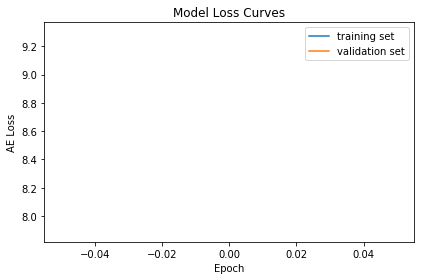

In [14]:
loss     = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
fig = plt.figure()
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss Curves')
plt.ylabel('AE Loss')
plt.xlabel('Epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig('ae_history_Left_Caudate.png', dpi=600)

In [15]:
selectedepoch = 50
loadmodel = True
if loadmodel:
    ae_train.load_weights('Left_Caudate_weights{0:08d}'.format(selectedepoch)+'.h5')

In [16]:
Original_Codes = np.zeros((Data_proj1.shape[0],3,latent_dim))
# generate latent codes
idx = 0
for filename in os.listdir('./SubcorticalImages/Caudate/'):
    if filename.endswith('CaudL_pp_surfSPHARM_procalign_proj1.nrrd'): 
        image = sitk.ReadImage(os.path.join('./SubcorticalImages/Caudate/', filename))
        image_array = np.squeeze(np.asarray(sitk.GetArrayFromImage(image)))
        image_array = np.array(image_array, dtype=bool)
        image_resized = resize(image_array, (64, 64), mode='constant', anti_aliasing=False)
        x = np.expand_dims(np.expand_dims(image_resized,  axis=-1), axis=0)
        z = Enc.predict(x)
        Original_Codes[idx,0,:] = z
        name, _ = os.path.splitext(filename)
        with open(os.path.join('./SubcorticalImages/Caudate/Code/', name + '.pkl'),'wb') as f:
            pickle.dump(z, f)
        idx += 1

idx = 0
for filename in os.listdir('./SubcorticalImages/Caudate/'):
    if filename.endswith('CaudL_pp_surfSPHARM_procalign_proj2.nrrd'): 
        image = sitk.ReadImage(os.path.join('./SubcorticalImages/Caudate/', filename))
        image_array = np.squeeze(np.asarray(sitk.GetArrayFromImage(image)))
        image_array = np.array(image_array, dtype=bool)
        image_resized = resize(image_array, (64, 64), mode='constant', anti_aliasing=False)
        x = np.expand_dims(np.expand_dims(image_resized,  axis=-1), axis=0)
        z = Enc.predict(x)
        Original_Codes[idx,1,:] = z
        name, _ = os.path.splitext(filename)
        with open(os.path.join('./SubcorticalImages/Caudate/Code/', name + '.pkl'),'wb') as f:
            pickle.dump(z, f)
        idx += 1

idx = 0
for filename in os.listdir('./SubcorticalImages/Caudate/'):
    if filename.endswith('CaudL_pp_surfSPHARM_procalign_proj3.nrrd'): 
        image = sitk.ReadImage(os.path.join('./SubcorticalImages/Caudate/', filename))
        image_array = np.squeeze(np.asarray(sitk.GetArrayFromImage(image)))
        image_array = np.array(image_array, dtype=bool)
        image_resized = resize(image_array, (64, 64), mode='constant', anti_aliasing=False)
        x = np.expand_dims(np.expand_dims(image_resized,  axis=-1), axis=0)
        z = Enc.predict(x)
        Original_Codes[idx,2,:] = z
        name, _ = os.path.splitext(filename)
        name, _ = os.path.splitext(filename)
        with open(os.path.join('./SubcorticalImages/Caudate/Code/', name + '.pkl'),'wb') as f:
            pickle.dump(z, f)
        idx += 1

In [17]:
# Save Codes
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Original_Codes.pkl'),'wb') as f:
    pickle.dump(Original_Codes, f)

In [18]:
# Split Data to Training and Testing
Train_Test_IDx = np.zeros((Data_proj1.shape[0],))
Train_Test_IDx[0:int(0.2*Data_proj1.shape[0])] = 1
np.random.shuffle(Train_Test_IDx)

Original_Images_Train = Original_Images[Train_Test_IDx==0,:,:,:]
Original_Images_Test  = Original_Images[Train_Test_IDx==1,:,:,:]
Original_Codes_Train  = Original_Codes[Train_Test_IDx==0,:,:]
Original_Codes_Test   = Original_Codes[Train_Test_IDx==1,:,:]

In [19]:
# Save Splitted Original Data
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Original_Images_Train.pkl'),'wb') as f:
    pickle.dump(Original_Images_Train, f)
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Original_Images_Test.pkl'),'wb') as f:
    pickle.dump(Original_Images_Test, f)
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Original_Codes_Train.pkl'),'wb') as f:
    pickle.dump(Original_Codes_Train, f)
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Original_Codes_Test.pkl'),'wb') as f:
    pickle.dump(Original_Codes_Test, f)

In [20]:
Inhomogeneous_Images_Train = Original_Images_Train
Inhomogeneous_Images_Test  = Original_Images_Test
Inhomogeneous_Codes_Train  = Original_Codes_Train
Inhomogeneous_Codes_Test   = Original_Codes_Test

# Create Inhomogenous Data (Train)
for i in range(Inhomogeneous_Images_Train.shape[0]):
    #Select projection item to replace
    proj = randint(0, 2)
    #Select Subject Data for replaement
    j = randint(0, Inhomogeneous_Images_Train.shape[0]-1)
    Inhomogeneous_Images_Train[i,proj,:,:] = Original_Images_Train[j,proj,:,:]
    Inhomogeneous_Codes_Train[i,proj,:]    = Original_Codes_Train[j,proj,:]

for i in range(Inhomogeneous_Images_Test.shape[0]):
    #Select projection item to replace (Test)
    proj = randint(0, 2)
    #Select Subject Data for replaement
    j = randint(0, Inhomogeneous_Images_Test.shape[0]-1)
    Inhomogeneous_Images_Test[i,proj,:,:]  = Original_Images_Test[j,proj,:,:]
    Inhomogeneous_Codes_Test[i,proj,:]     = Original_Codes_Test[j,proj,:]

In [21]:
# Save Splitted Inhomogenous Data
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Inhomogeneous_Images_Train.pkl'),'wb') as f:
    pickle.dump(Inhomogeneous_Images_Train, f)
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Inhomogeneous_Images_Test.pkl'),'wb') as f:
    pickle.dump(Inhomogeneous_Images_Test, f)
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Inhomogeneous_Codes_Train.pkl'),'wb') as f:
    pickle.dump(Inhomogeneous_Codes_Train, f)
with open(os.path.join('./SubcorticalImages/Caudate/ToSam/L/Inhomogeneous_Codes_Test.pkl'),'wb') as f:
    pickle.dump(Inhomogeneous_Codes_Test, f)